# Estimating the SCC using CIL damage functions and the FAIR SCM

This notebook builds on the [FAIR example notebook](./Example-Usage.ipynb) and adds an SCC simulation using damage functions from the Climate Impact Lab's mortality work.

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2015
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

All of this work and the source data can be found in the Climate Impact Lab's [FAIR-SCM repo](https://gitlab.com/ClimateImpactLab/Climate/FAIR-SCM) on gitlab.

Version 0.3 update 6/22/18:
Version 0.3 updates the damages calculation to take the linear extrapolation of the quadratic damage function for post-2100 periods as one alternative, or to hold the damage function constant at 2100 values for another alternative, and output both results. In addition, it is formatted to accept multiple scenarios within a given damage function .csv file, and select one of them for analysis and output.

Update 10/4/18: Updated the FAIR temperature anomaly from 0.8C to 0.6C per Bob's instructions.

## Set up workspace

In [1]:
%matplotlib inline

In [2]:
! pip install fair==1.3.2

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [3]:
import sys
sys.path.append('..')

import fair
fair.__version__

u'1.3.2'

In [4]:
import numpy as np
import pandas as pd
import xarray as xr

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

# from scc import load_fair
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair

In [5]:
# Make this labor specific

model = "poly4_below0bin"
df = "quadratic"
clim_data = "GMFD"
#grp_test = "semi-parametric"
OUTPUT_path = "/home/liruixue/repos/labor-code-release-2020/output/damage_function"
INPUT_path = "/home/liruixue/repos/labor-code-release-2020/output/damage_function"

# SCC

We can compute the SCC by adding an additional pulse in CO2 emissions to the RCP trajectory.

--------------------------------------------------------------------------
## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four
representative concentration pathway scenarios.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions
of methane and nitrous oxide are switched on.

We can compute the SCC by adding an additional pulse in CO2 emissions to the
RCP trajectory.

This study uses a 1 Gt C emissions pulse. You can change the pulse amount by
modifying the PULSE_AMT variable. 

--------------------------------------------------------------------------

### Scenario design

This study uses a 100 Gt C emissions pulse. You can change the pulse amount by modifying the `PULSE_AMT` variable below, and adapting the `CONVERSION` value to match.

In [6]:
PULSE_YEAR = 2015  # year in which pulse will be emitted
PULSE_AMT = 1.0  # in Gt C = 1e9 ton C

# CONVERSION is in units of [pulse/tCO2] = [1 pulse/PULSE_AMT GtC * 1 GtC/1e9 tC * 12tC/44tCO2]
# This is used to convert costs ($Bn / pulse) to SCC ($/ton CO2), but the $Bn to $ conversion is separate.
# Therefore, it should be the inverse of any changes to PULSE_AMT
CONVERSION = 1.0 / PULSE_AMT / 1e9 * 12.011 / 44.0098

In [7]:
fair_temperatures_anomaly = load_fair.temperatures_anomaly(PULSE_YEAR = PULSE_YEAR, PULSE_AMT = PULSE_AMT, make_plots = False, output = OUTPUT_path)

Finished loading FAIR


## Incorporate a single damage function

This is the damage function from Tamma, with a set of coefficients for each year.

Version 0.3 update: The damage function can now be held constant or allowed to vary post-2100. Additionally, different valuation scenarios can be selected within the damage function .csv file. See comments in the document header. 

Note: damages are estimated in  2005 \$PPP, so use the U.S. GDP deflator for 2005 from the World Bank. Take the ratio with the `PULSE_YEAR` deflator (U.S. GDP deflator for the pulse_year from the World Bank) to convert the dollars from 2005 \$PPP to `PULSE_YEAR` $PPP.

In [8]:

version = 'v0.3'

# change stuff here #
specification = 'labor_main_model'
stem = "damage_function_estimation"
#######################

MAGNITUDE_OF_DAMAGES = 1  # magnitude of damage function values
DAMAGES_DEFLATOR = 90.8776 # Damages based year is 2005, with this World Bank US GDP deflator
PULSE_DEFLATOR = 108.6850 # Update for the pulse base year (currently 2015) -- use the World Bank US GDP deflator for that year.
BASE_YEAR_CONVERSION = 1
# PULSE_DEFLATOR / DAMAGES_DEFLATOR  # Converts from Damages_year $ to Pulse_year $

# Toggle to generate plots or not
generate_plots = True

# Run options: which damages scenario to run, and whether or not to hold the post-2100 damage function constant.
# scenario_to_run = 'peakprice014'  # 'price0', 'price014', 'price03', 'price05', 'peakprice014'
hold_2100_damages_fixed = False
damage_func_form = df # 'quadratic' or 'cubic'

import os, glob

# Time the SCC calculation
startTime = datetime.now()

# Make sure the 'year' and 'growth_rate' columns are the first two columns in the damage function .csv
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))


In [9]:
fps 

['/home/liruixue/repos/labor-code-release-2020/output/damage_function/damage_function_estimation.csv']

In [10]:
def read_damage_func(fp):
    data = pd.read_csv(fps[0], index_col = [3])
    data = data[["cons","beta1","beta2"]]
    data.columns.names = ['coeff']
    return data.stack('coeff').to_xarray()

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})

In [11]:
ds

<xarray.Dataset>
Dimensions:                     (coeff: 3, year: 286)
Coordinates:
  * year                        (year) int64 2015 2016 2017 ... 2298 2299 2300
  * coeff                       (coeff) object 'cons' 'beta1' 'beta2'
Data variables:
    damage_function_estimation  (year, coeff) float64 1.78e+09 ... 5.52e+11

In [12]:
# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it.

####### Change stuff here to deal with placeholders
coeffs_all_years = (
    ds.to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2015, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)
###########################

# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)

In [13]:
coeffs_all_years = coeffs_all_years.sel(variable=stem)
coeffs_all_years

<xarray.Dataset>
Dimensions:   (year: 286)
Coordinates:
    variable  |S26 'damage_function_estimation'
  * year      (year) int64 2015 2016 2017 2018 2019 ... 2296 2297 2298 2299 2300
Data variables:
    beta1     (year) float64 9.42e+09 2.84e+10 8.79e+10 ... -4.2e+11 -4.22e+11
    beta2     (year) float64 1.57e+11 9.32e+10 -1.12e+11 ... 5.5e+11 5.52e+11
    cons      (year) float64 1.78e+09 2.71e+09 8.9e+08 ... -5.12e+11 -5.17e+11

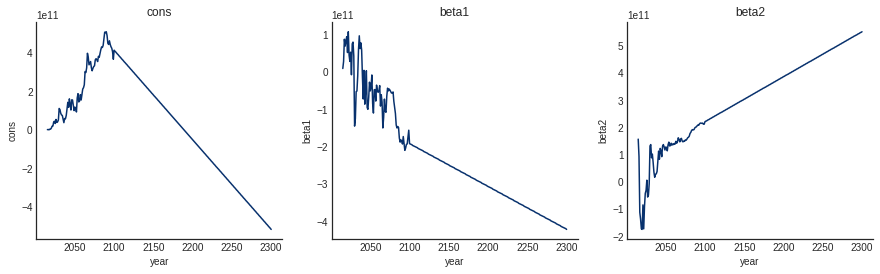

In [14]:
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, coeff in enumerate(['cons', 'beta1', 'beta2']):
        lines = coeffs_all_years[coeff].plot.line(
            x='year', ax=axes[i], add_legend=False, 
            color=matplotlib.cm.Blues_r(1) )
        axes[i].set_title(coeff)

    sns.despine()

/home/liruixue/miniconda3/envs/risingverse-py27/lib/python2.7/site-packages/matplotlib/legend.py:1363: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


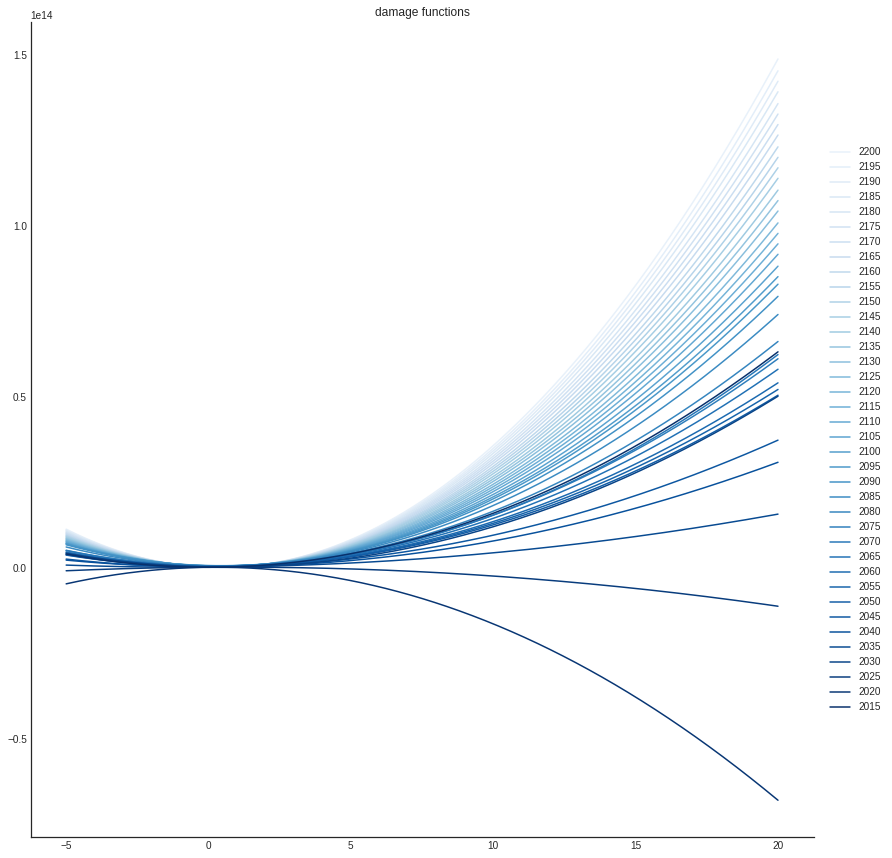

In [15]:
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = 1
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    lines = []
    for y in reversed(coeffs_all_years.year.values[:186:5]):
        lines.append(
            axes[0,0].plot(
                temps.values,
                spaghetti.sel(year=y).values,
                color=matplotlib.cm.Blues_r((y-2015.0)/(2200-2000)),
                label=int(y)))

    axes[0,0].set_facecolor('white')
    axes[0,0].set_title("damage functions")

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::5],
        labels=list(reversed(coeffs_all_years.year.values[:186]))[::5],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    fig.savefig('{}/damage_functions_{}_{}_{}_2200-fixed-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2100_damages_fixed))
    

### Compute damages

Combine the damage function coefficients with the FAIR temperatures:

$$d_y = c_2*T_y^2+C_1*T_y+C_0 \hspace{1in}\forall \hspace{0.1in} y \in [2015, 2300]$$

In [16]:
# Just checking things out

coeffs_all_years.to_array('coeff')
powers
fair_temperatures_anomaly
#fair_temperatures_anomaly ** powers
#coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)

<xarray.DataArray (pulse: 2, rcp: 4, year: 736)>
array([[[-0.964808, -0.960404, ..., -0.080137, -0.08179 ],
        [-0.964817, -0.960413, ...,  2.233849,  2.235075],
        [-0.962684, -0.95828 , ...,  3.633665,  3.635488],
        [-0.968932, -0.964528, ...,  8.447973,  8.451678]],

       [[-0.964808, -0.960404, ..., -0.078538, -0.080192],
        [-0.964817, -0.960413, ...,  2.235488,  2.236714],
        [-0.962684, -0.95828 , ...,  3.635195,  3.637018],
        [-0.968932, -0.964528, ...,  8.448641,  8.452345]]])
Coordinates:
  * pulse    (pulse) |S5 'rcp' 'pulse'
  * rcp      (rcp) |S5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * year     (year) float64 1.765e+03 1.766e+03 1.767e+03 ... 2.499e+03 2.5e+03

In [17]:
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

damages = (
    (coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)).sum(dim='coeff')*BASE_YEAR_CONVERSION)

# Fix the coordinate re-order bug introduced by holding the damage function constant post-2100.
damages = damages.transpose('year', 'pulse', 'rcp')

In [18]:
damages = damages.sel(rcp=['rcp45', 'rcp85'])

damages

<xarray.DataArray (year: 286, pulse: 2, rcp: 2)>
array([[[7.138411e+09, 8.890506e+09],
        [7.138411e+09, 8.890506e+09]],

       [[9.999672e+09, 1.202551e+10],
        [9.999672e+09, 1.202551e+10]],

       ...,

       [[7.635786e+11, 2.596918e+13],
        [7.662685e+11, 2.597490e+13]],

       [[7.597073e+11, 2.609269e+13],
        [7.624049e+11, 2.609844e+13]]])
Coordinates:
  * year      (year) float64 2.015e+03 2.016e+03 2.017e+03 ... 2.299e+03 2.3e+03
    variable  |S26 'damage_function_estimation'
  * pulse     (pulse) |S5 'rcp' 'pulse'
  * rcp       (rcp) |S5 'rcp45' 'rcp85'

### Plot time series of damages

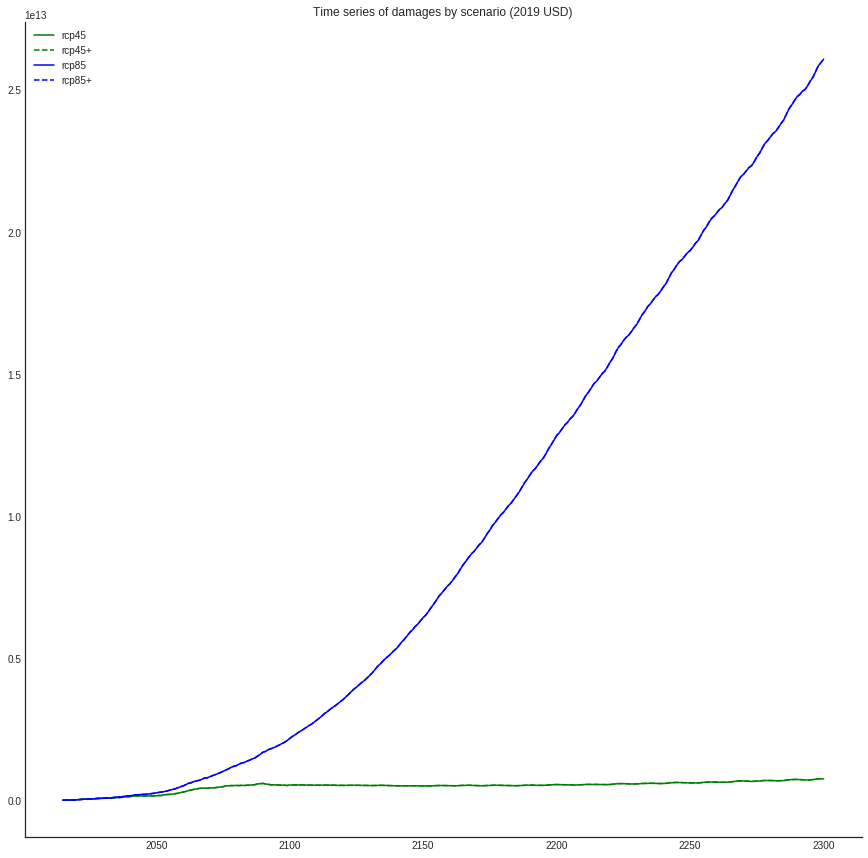

In [19]:
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    numvars = 1
    fig, ax = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    colors = ['green', 'blue', 'red', 'black']
    styles = ['solid', 'dashed']

    lines = []
    labels = []
    for r, rcp in enumerate(damages.rcp.values):
        for p, pulse in enumerate(damages.pulse.values):

            labels.append('{}{}'.format(rcp, ['', '+'][p]))
            lines.append(
                ax.plot(
                    damages.year,
                    damages.sel(rcp=rcp, pulse=pulse),
                    color=colors[r],
                    linestyle=styles[p])[0])

    ax.set_title('Time series of damages by scenario (2019 USD)')
    ax.legend(lines, labels)
                

    #plt.legend(lines, labels)
    #ax.axes.set_title(
    #    'Time series of damages by scenario (2019 USD)',
    #    size=14)

    sns.despine()

    fig.savefig('{}/damage_projections_{}_{}_{}_2100-fixed-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2100_damages_fixed))
    

### Plot time series of damages incurred due to pulse

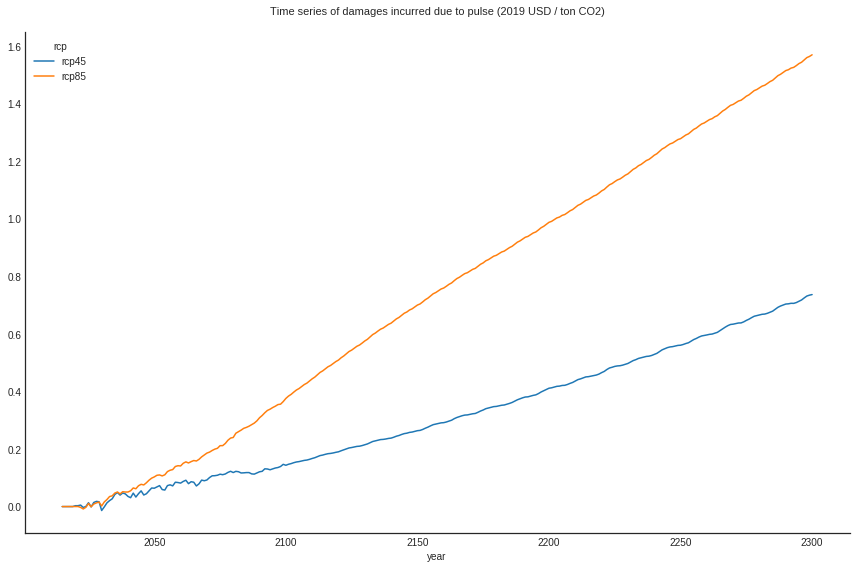

In [20]:
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

#    for vi, var in enumerate(damages['growth_rate'].values):
    (damages * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[0,0])
    axes[0,0].axes.set_title(
        'Time series of damages incurred due to pulse (2019 USD / ton CO2)\n',
        size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/damage_projections_pulse_{}_{}_{}_2100-fixed-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2100_damages_fixed))

### Compue the SCC (NPV of damages)

discount the time series of damages using the formula

$$SCC=\sum_{y\in\left[2015, 2300\right]}{\frac{d_y}{\left({1+r}\right)^{y-2015}}}$$

### Plot the current equivalent damage time series

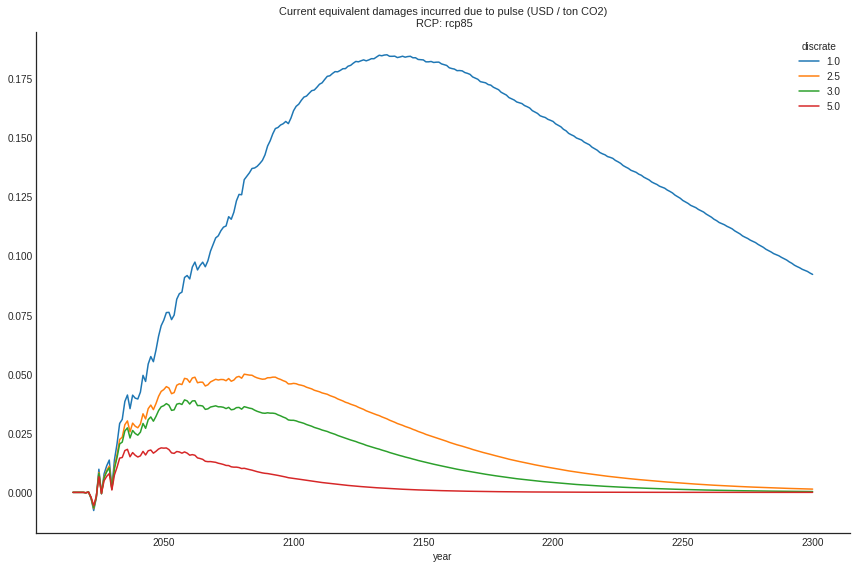

In [21]:
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

discrates = [1.,2.5, 3., 5.]

discdata = []
for r in discrates:
    discdata.append(damages / (1+r/100)**(damages.year - 2015))

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

rcp = 'rcp85'
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    (current_equivalent_damages.sel(rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[0,0])
    axes[0,0].axes.set_title(
        'Current equivalent damages incurred due to pulse (USD / ton CO2)\n RCP: {}'.format(rcp),
        size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/current_equivalent_damage_projections_pulse_{}_{}_{}-fixed-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2100_damages_fixed))
    # plt.savefig('../outputs/images/current_equivalent_damage_projections_pulse_{}_{}.pdf'.format(specification, version))
    


In [22]:
current_equivalent_damages['rcp'].values

array(['rcp45', 'rcp85'], dtype='|S5')

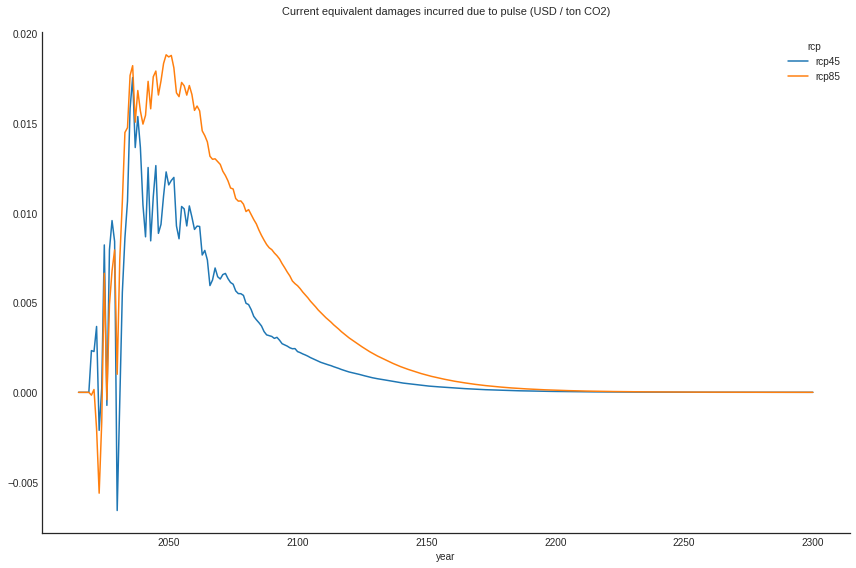

In [23]:
# Look at 0.5% discount rate
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    (current_equivalent_damages.sel(discrate=5.) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[0,0])
    axes[0,0].axes.set_title(
        'Current equivalent damages incurred due to pulse (USD / ton CO2)\n',
        size=11)

    sns.despine()
    plt.tight_layout()
    # plt.savefig('../outputs/images/current_equivalent_damage_projections_pulse_{}_{}.pdf'.format(specification, version))
    

In [24]:
#max(current_equivalent_damages.sel(year=slice(2015, 2099))['year'])
#min(current_equivalent_damages.sel(year=slice(2015, 2099))['year'])
current_equivalent_damages.sel(year=slice(2015, 2099))

<xarray.DataArray (discrate: 4, year: 85, pulse: 2, rcp: 2)>
array([[[[7.138411e+09, 8.890506e+09],
         [7.138411e+09, 8.890506e+09]],

        ...,

        [[2.273426e+11, 9.124796e+11],
         [2.275756e+11, 9.130587e+11]]],


       ...,


       [[[7.138411e+09, 8.890506e+09],
         [7.138411e+09, 8.890506e+09]],

        ...,

        [[8.705127e+09, 3.493956e+10],
         [8.714049e+09, 3.496174e+10]]]])
Coordinates:
  * year      (year) float64 2.015e+03 2.016e+03 ... 2.098e+03 2.099e+03
    variable  |S26 'damage_function_estimation'
  * pulse     (pulse) |S5 'rcp' 'pulse'
  * rcp       (rcp) |S5 'rcp45' 'rcp85'
  * discrate  (discrate) float64 1.0 2.5 3.0 5.0

### Plot SCC (sum of discounted marginal damage time series) by discount rate and RCP

In [25]:
scc = (
    (current_equivalent_damages.diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_pre_2100 = (
    (current_equivalent_damages.sel(year=slice(2015, 2099)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_post_2100 = (
    (current_equivalent_damages.sel(year=slice(2100, 3000)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_share_post2100 = (
    scc_post_2100 / scc)

scc = xr.concat([scc, scc_pre_2100, scc_post_2100, scc_share_post2100], pd.Index(['all', 'pre2100', 'post2100', 'share_post2100'], name='time_cut'))


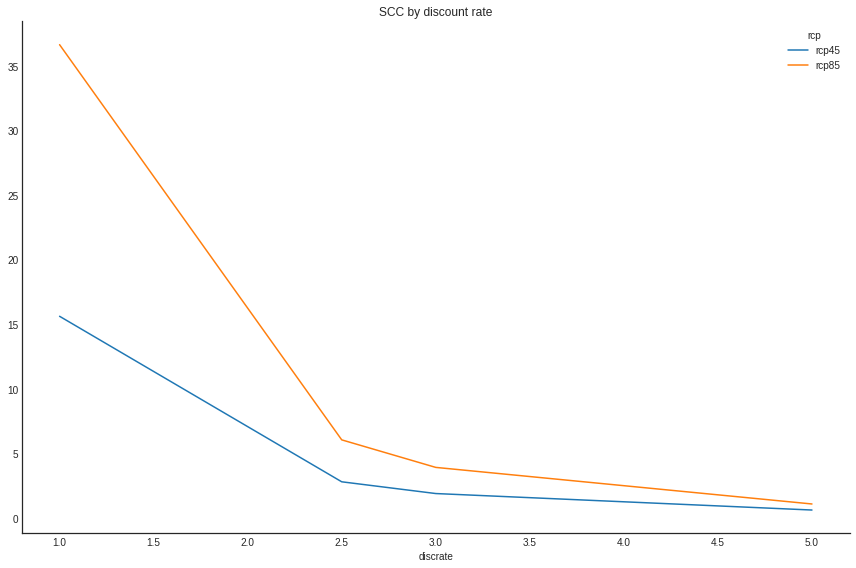

In [26]:
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    scc.sel(time_cut='all').plot.line(x='discrate', ax=axes[0,0])
    axes[0,0].set_title('SCC by discount rate')

    plt.savefig('{}/scc_{}_{}_{}_2100-fixed-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2100_damages_fixed))
    plt.tight_layout()
    sns.despine()

### Export SCC to CSV

In [27]:
(
    scc
    .to_series()
    .unstack('rcp')
    .to_csv('{}/scc_{}_pulse{}GtC_{}_{}_2100-fixed-{}_test.csv'.format(OUTPUT_path, specification, PULSE_AMT, version, damage_func_form, hold_2100_damages_fixed)))

print(datetime.now() - startTime)

0:00:04.313670


In [28]:
OUTPUT_path

'/home/liruixue/repos/labor-code-release-2020/output/damage_function'

In [29]:
pwd

u'/home/liruixue/repos/labor-code-release-2020/4_post_projection/3_scc'